<a href="https://colab.research.google.com/github/lethanhnam1203/Machine-Deep-Learning-/blob/main/VAE_on_MNIST_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torchvision import datasets
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import save_image , make_grid
from tqdm import tqdm

In [2]:
dataset_path = '~/datasets'
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

In [3]:
# Load the MNIST Dataset
dataset_path = '~/datasets'
mnist_transform = transforms.Compose([transforms.ToTensor()])
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=256, shuffle=False, **kwargs)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Task a: Implement and train a variational autoencoder on the MNIST dataset
Compared to using Conv2D, the results of not using Conv2D were not worse

In [4]:
class Encoder(nn.Module):
    """
    Encoder of VAE
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2*latent_dim)
        self.fc_z_mean = nn.Linear(2*latent_dim, latent_dim)
        self.fc_z_log_var = nn.Linear(2*latent_dim, latent_dim)
        self.relu = nn.ReLU()
        self.training = True
        
    def forward(self, x):
        """
        From input x, we generate z_mean and z_log_var for later sampling
        """
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        z_mean = self.fc_z_mean(out)
        z_log_var = self.fc_z_log_var(out)                     
        return z_mean, z_log_var

In [5]:
class Decoder(nn.Module):
    """
    Decoder of VAE
    """
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 2*latent_dim)
        self.fc2 = nn.Linear(2*latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.training = True
        
    def forward(self, z):
        """
        Reconstruct x_hat from z, obtained after sampling
        """
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)    
        out = self.fc3(out)
        x_hat = self.sigmoid(out)
        return x_hat

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.Encoder = Encoder(input_dim=input_dim , hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.Decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = output_dim)
        self.training = True
        
    def sample(self, z_mean, z_log_var):
        """
        Sample z based on z_mean and z_var
        """
        epsilon = torch.randn_like(z_mean).to(DEVICE)             
        z = z_mean + torch.exp(0.5 * z_log_var) * epsilon                        
        return z
                
    def forward(self, x):
        """
        encode x, sample to get z and decode to get x_hat
        """
        z_mean, z_log_var = self.Encoder(x)
        z = self.sample(z_mean, z_log_var) 
        x_hat = self.Decoder(z)
        return x_hat, z_mean, z_log_var

In [7]:
def compute_elbo_loss(x, x_hat, z_mean, z_log_var):
    """
    Compute ELBO as a sum of reconstruction_loss and kl_divergence_loss
    """
    reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_divergence_loss = - 0.5 * torch.sum(1+ z_log_var - z_mean.pow(2) - z_log_var.exp())
    elbo = reconstruction_loss + kl_divergence_loss
    return elbo

In [8]:
model = VAE(input_dim=784, hidden_dim=400, latent_dim=20, output_dim=784).to(DEVICE)
model.train()
optimizer = optim.Adam(model.parameters(), lr=1.5e-3)

In [9]:
loss_history = {}
epochs = 25
for epoch in range(epochs):
    total_loss = 0
    for batch_index, (x, _) in enumerate(train_loader):
        x = x.view(x.size(0), -1).to(DEVICE)
        optimizer.zero_grad()
        x_hat, z_mean, z_log_var = model(x)
        elbo = compute_elbo_loss(x, x_hat, z_mean, z_log_var)
        total_loss += elbo.item()      
        elbo.backward()
        optimizer.step()
    avg_loss = total_loss/(batch_index*256)  
    loss_history[epoch] = avg_loss
    print("Epoch", epoch + 1, "\tELBO: ", avg_loss)

Epoch 1 	ELBO:  202.93736118740506
Epoch 2 	ELBO:  152.02542094695264
Epoch 3 	ELBO:  138.2712830926618
Epoch 4 	ELBO:  130.21491939186032
Epoch 5 	ELBO:  124.59093454149034
Epoch 6 	ELBO:  121.03951636746399
Epoch 7 	ELBO:  118.73406431410048
Epoch 8 	ELBO:  116.77598377782056
Epoch 9 	ELBO:  115.27180242946005
Epoch 10 	ELBO:  114.24696575066982
Epoch 11 	ELBO:  113.33211944449661
Epoch 12 	ELBO:  112.64511217622676
Epoch 13 	ELBO:  112.09278049632016
Epoch 14 	ELBO:  111.4747540726621
Epoch 15 	ELBO:  110.92114618089464
Epoch 16 	ELBO:  110.38683244102022
Epoch 17 	ELBO:  109.90787753895816
Epoch 18 	ELBO:  109.31877336746606
Epoch 19 	ELBO:  108.83762237353203
Epoch 20 	ELBO:  108.447722883306
Epoch 21 	ELBO:  108.24738531846266
Epoch 22 	ELBO:  107.9182937328632
Epoch 23 	ELBO:  107.59116585234291
Epoch 24 	ELBO:  107.43641074090941
Epoch 25 	ELBO:  107.16005291082921


## Task d: Plot the value of the ELBO during training

In [10]:
# Plot the history of elbo during training
def visualise_elbo(loss_history):
  """
  Visualise the history of ELBO during training the VAE
  Input:
    loss_history -- dict 
  """
  x = list(loss_history.keys())
  y = list(loss_history.values())
  plt.plot(x, y)
  plt.scatter(x, y, color='r')
  plt.xlabel('Epoch')
  plt.ylabel('ELBO')
  plt.title('ELBO during Training')
  plt.show()

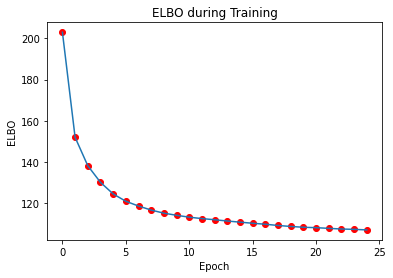

In [11]:
visualise_elbo(loss_history)

## Task b: Visualize the reconstructions learned by the network for some test data

In [12]:
# Trick: make a single huge batch
new_test_loader  = DataLoader(dataset=test_dataset,  batch_size=len(test_dataset), shuffle=False, **kwargs)

In [13]:
model.eval()
with torch.no_grad():
    for batch_index, (x, _) in enumerate(new_test_loader):
        x = x.view(x.size(0), -1).to(DEVICE)     
        x_hat, _, _ = model(x)
        break

In [16]:
def show_image(x, x_hat, index):
    x = x.view(10000, 28, 28)
    x_hat = x_hat.view(10000, 28, 28)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(x[index].cpu().numpy(), cmap='gray')
    ax1.set_title("Original Image")
    ax2.imshow(x_hat[index].cpu().numpy(), cmap='gray')
    ax2.set_title("Reconstructed Image")

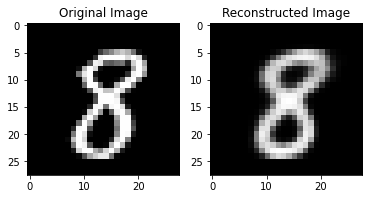

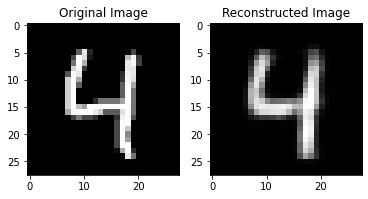

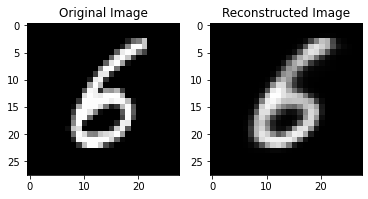

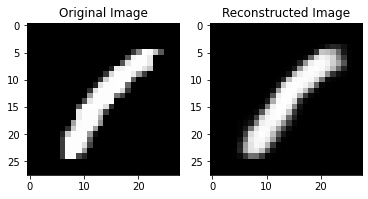

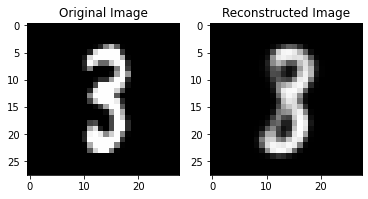

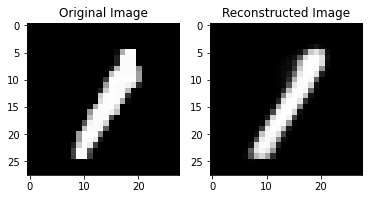

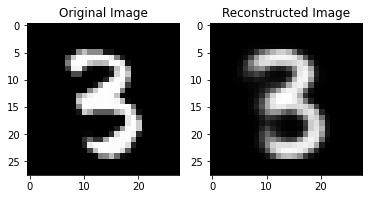

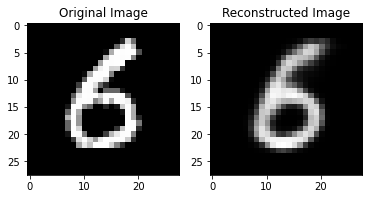

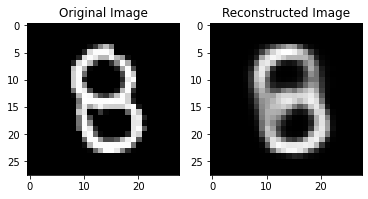

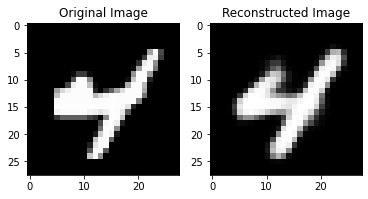

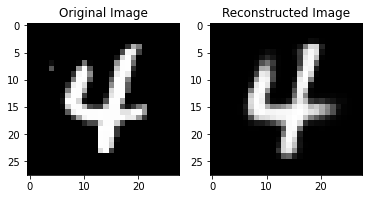

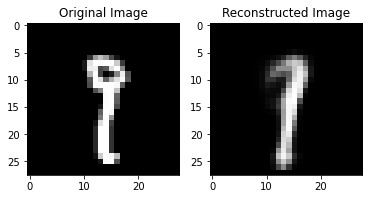

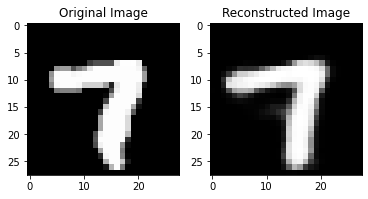

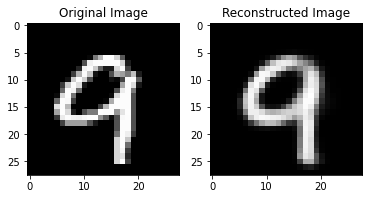

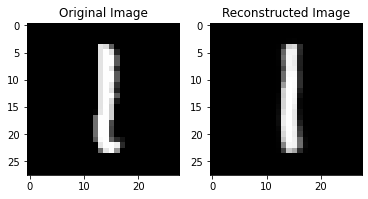

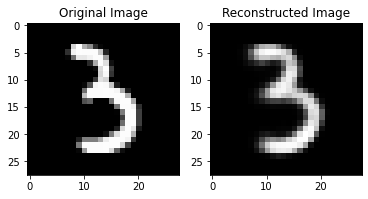

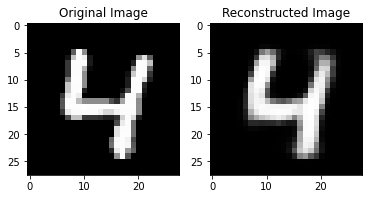

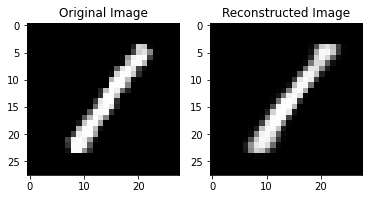

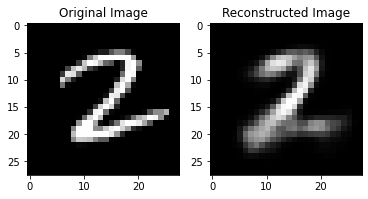

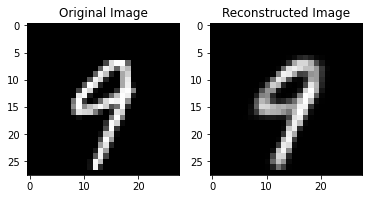

In [17]:
number_of_samples = 20
samples = np.random.randint(0, 10000, number_of_samples)
for sample in samples:
    show_image(x, x_hat, sample)

## Task c: For the test data sample from the latent space and create a scatter plot of thosesamples

In [18]:
model.eval()
with torch.no_grad():
    for batch_index, (x, y) in enumerate(new_test_loader):
        x = x.view(x.size(0), -1).to(DEVICE)     
        break
    z_mean, z_log_var = model.Encoder(x)
    z = model.sample(z_mean, z_log_var)
    z = z.cpu().numpy()
    principal=PCA(n_components=3)
    principal.fit(z)
    new_z=principal.transform(z)

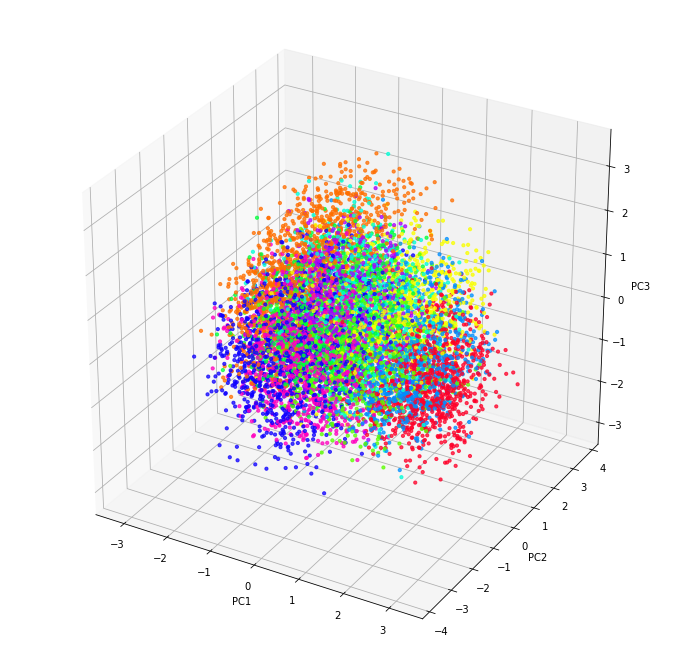

In [19]:
fig = plt.figure(figsize=(12,12))
axis = fig.add_subplot(111, projection='3d')
axis.scatter(new_z[:,0],new_z[:,1],new_z[:,2], c=y, cmap='gist_rainbow',alpha=0.75, s=10)
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)
plt.show()